# Regularization with Data

## Hashing high cardinality features


In [1]:
from hashlib import md5

print('hashing of "regularization" ->', md5(b'regularization').hexdigest())
print('hashing of "regularized" ->', md5(b'regularized').hexdigest())
print('hashing of "machine learning" ->', md5(b'machine learning').hexdigest())

hashing of "regularization" -> 04ef847b5e35b165c190ced9d91f65da
hashing of "regularized" -> bb02c45d3c38892065ff71198e8d2f89
hashing of "machine learning" -> e04d1bcee667afb8622501b9a4b4654d


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders.hashing import HashingEncoder
from sklearn.linear_model import LogisticRegression

In [3]:
!kaggle datasets download -d reddynitin/aug-train

aug-train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
df = pd.read_csv('aug-train.zip')
print('number of unique values for the feature city', df['city'].nunique())

number of unique values for the feature city 123


In [5]:
df = df.drop(columns=['gender', 'major_discipline', 'company_size', 'company_type'])
df = df.dropna()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['target']), df['target'], stratify=df['target'], test_size=0.2, random_state=0
)

In [7]:
quanti_feats = ['city_development_index', 'training_hours']
# Instantiate the scaler
scaler = StandardScaler()
# Select quantitative features
X_train_quanti = X_train[quanti_feats]
X_test_quanti = X_test[quanti_feats]
# Rescale quantitative features
X_train_quanti = scaler.fit_transform(X_train_quanti)
X_test_quanti = scaler.transform(X_test_quanti)

In [8]:
quali_feats = ['relevent_experience', 'enrolled_university', 'education_level', 'experience', 'last_new_job']
quali_feats = ['last_new_job']

# Instantiate the one hot encoder
encoder = OneHotEncoder()
# Select qualitative features to one hot encode
X_train_quali = X_train[quali_feats]
X_test_quali = X_test[quali_feats]
# Encode those features
X_train_quali = encoder.fit_transform(X_train_quali).toarray()
X_test_quali = encoder.transform(X_test_quali).toarray()

In [9]:
high_cardinality_feature = ['city']
# Instantiate the hashing encoder
hasher = HashingEncoder(n_components=7)
# Encode the city feature with hashing
X_train_hash = hasher.fit_transform(X_train[high_cardinality_feature])
X_test_hash = hasher.fit_transform(X_test[high_cardinality_feature])
# Display the result on the training set
X_train_hash.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6
18031,1,0,0,0,0,0,0
16295,0,0,0,1,0,0,0
7679,0,0,0,0,0,1,0
18154,0,0,1,0,0,0,0
10843,0,0,0,0,0,1,0


In [10]:
X_train = np.concatenate([X_train_quali, X_train_quanti, X_train_hash], 1)
X_test = np.concatenate([X_test_quali, X_test_quanti, X_test_hash], 1)

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [12]:
print('Accuracy train set:', lr.score(X_train, y_train))
print('Accuracy test set:', lr.score(X_test, y_test))

Accuracy train set: 0.7812087988342239
Accuracy test set: 0.7826810990840966


## Aggregating

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [14]:
df = pd.read_csv('aug-train.zip')

In [15]:
df = df.drop(columns=['gender', 'major_discipline', 'company_size', 'company_type'])
df = df.dropna()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['target']), df['target'], stratify=df['target'], test_size=0.2, random_state=0
)

In [17]:
quanti_feats = ['city_development_index', 'training_hours']
scaler = StandardScaler()
X_train_quanti = X_train[quanti_feats]
X_test_quanti = X_test[quanti_feats]
X_train_quanti = scaler.fit_transform(X_train_quanti)
X_test_quanti = scaler.transform(X_test_quanti)

In [18]:
# Get only cities above threshold
threshold = 0.1
kept_cities = X_train['city'].value_counts(normalize=True)[X_train['city'].value_counts(normalize=True) > threshold].index
# Update all cities below threshold as 'other'
X_train.loc[~X_train['city'].isin(kept_cities), 'city'] = 'other'
X_test.loc[~X_test['city'].isin(kept_cities), 'city'] = 'other'

In [19]:
# Get qualitative features
quali_feats = ['city', 'relevent_experience', 'enrolled_university', 'education_level', 'experience', 'last_new_job']
X_train_quali = X_train[quali_feats]
X_test_quali = X_test[quali_feats]
# Instantiate the one hot encoder
encoder = OneHotEncoder()
# Apply one hot encoding
X_train_quali = encoder.fit_transform(X_train_quali).toarray()
X_test_quali = encoder.transform(X_test_quali).toarray()

In [20]:
X_train = np.concatenate([X_train_quali, X_train_quanti], 1)
X_test = np.concatenate([X_test_quali, X_test_quanti], 1)

In [21]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [22]:
print('Accuracy train set:', lr.score(X_train, y_train))
print('Accuracy test set:', lr.score(X_test, y_test))

Accuracy train set: 0.7805842759003538
Accuracy test set: 0.774909797391063


In [23]:
df['city'].value_counts(normalize=True)

city
city_103    0.232819
city_21     0.136227
city_16     0.081659
city_114    0.069613
city_160    0.045354
              ...   
city_111    0.000167
city_129    0.000111
city_8      0.000111
city_140    0.000056
city_171    0.000056
Name: proportion, Length: 123, dtype: float64

In [24]:
df['city'].value_counts(normalize=True) > 0.05

city
city_103     True
city_21      True
city_16      True
city_114     True
city_160    False
            ...  
city_111    False
city_129    False
city_8      False
city_140    False
city_171    False
Name: proportion, Length: 123, dtype: bool

In [25]:
kept_cities = df['city'].value_counts(normalize=True)[df['city'].value_counts(normalize=True) > 0.05].index
kept_cities

Index(['city_103', 'city_21', 'city_16', 'city_114'], dtype='object', name='city')

## Undersampling an imbalanced dataset

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [27]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
df = pd.read_csv('creditcardfraud.zip')
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Class']), df['Class'], test_size=0.2, random_state=0, stratify=df['Class'])

In [30]:
# Instantiate the object with a 10% strategy
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=0)
# Undersample the train dataset
X_train, y_train = rus.fit_resample(X_train, y_train)
# Check the balance
y_train.value_counts()

Class
0    3940
1     394
Name: count, dtype: int64

In [31]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [33]:
# Get the probas
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]
# Display the ROC AUC
print('ROC AUC training set:', roc_auc_score(y_train, y_train_proba))
print('ROC AUC training set:', roc_auc_score(y_test, y_test_proba))

ROC AUC training set: 0.9875041871730784
ROC AUC training set: 0.9731067071595099


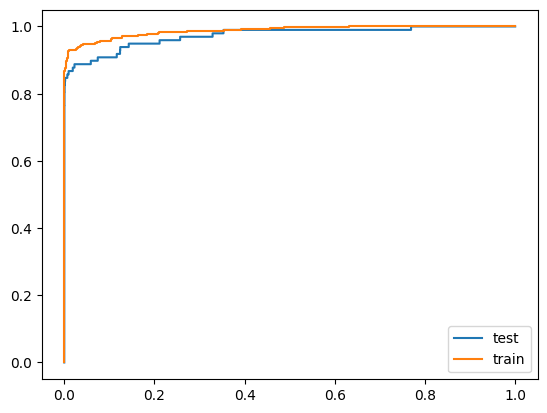

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
# Display the ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr_test, tpr_test, label='test')
plt.plot(fpr_train, tpr_train, label='train')
plt.legend()
plt.show()

## Oversampling an imbalanced dataset

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [36]:
df = pd.read_csv('creditcardfraud.zip')
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Class']), df['Class'], test_size=0.2, random_state=0, stratify=df['Class'])

In [38]:
# Instantiate the oversampler with a 10% strategy
ros = RandomOverSampler(sampling_strategy=0.1, random_state=0)
# Overersample the train dataset
X_train, y_train = ros.fit_resample(X_train, y_train)
# Check the balance
y_train.value_counts()

Class
0    227451
1     22745
Name: count, dtype: int64

In [39]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Get the probas
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]
# Display the ROC AUC
print('ROC AUC training set:', roc_auc_score(y_train, y_train_proba))
print('ROC AUC training set:', roc_auc_score(y_test, y_test_proba))

ROC AUC training set: 0.9877348596242091
ROC AUC training set: 0.9722444636971277


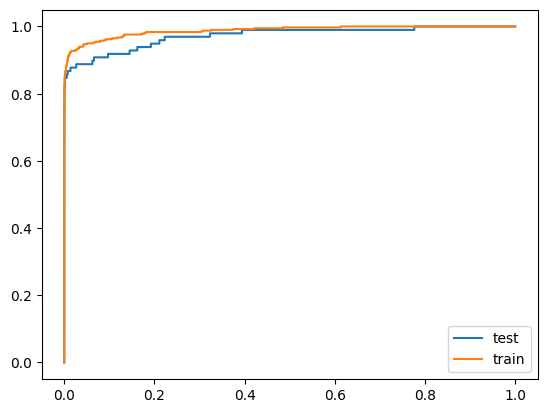

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
# Display the ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr_test, tpr_test, label='test')
plt.plot(fpr_train, tpr_train, label='train')
plt.legend()
plt.show()

## Resampling imbalanced data with SMOTE

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [44]:
df = pd.read_csv('creditcardfraud.zip')
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Class']), df['Class'], test_size=0.2, random_state=0, stratify=df['Class'])

In [46]:
# Instantiate the SLOT with a 10% strategy
smote = SMOTE(sampling_strategy=0.1, random_state=0)
# Overersample the train dataset
X_train, y_train = smote.fit_resample(X_train, y_train)
# Check the balance
y_train.value_counts()

Class
0    227451
1     22745
Name: count, dtype: int64

In [47]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [49]:
# Get the probas
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]
# Display the ROC AUC
print('ROC AUC training set:', roc_auc_score(y_train, y_train_proba))
print('ROC AUC training set:', roc_auc_score(y_test, y_test_proba))

ROC AUC training set: 0.9968657635906649
ROC AUC training set: 0.9711737923925902


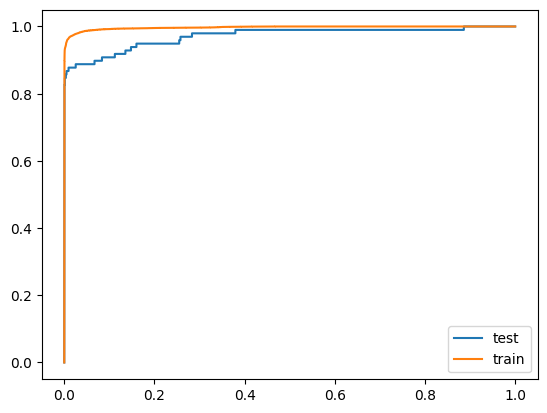

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
# Display the ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr_test, tpr_test, label='test')
plt.plot(fpr_train, tpr_train, label='train')
plt.legend()
plt.show()